## Motion correction with 2-photon imaging data using ANTs

We noticed in preliminary analyses that ants.motion_correction() sometimes failed badly on 2-photon imaging data, whereas ants.registration() had worked in previous analyses.  This notebook applies both workflows (with both SyN and Rigid transforms) to a small test dataset.

Summary:
- 

In [1]:
import ants
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('../scripts')
sys.path.append('../brainsss')
from timeit import default_timer as timer
from ants_utils import get_motion_parameters_from_transforms


In [2]:
# setup utility functions

def plot_image_means(antsimg, slice_to_show=20):
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    imgmeans = antsimg.mean(axis=(0,1,2))
    plt.plot(imgmeans)
    plt.ylabel('total image mean')
    plt.subplot(1,3,2)
    plt.imshow(
        antsimg[:,:,slice_to_show, np.argmin(imgmeans)],
        cmap='gray')
    plt.title('signal from bad timepoint')
    plt.subplot(1,3,3)
    plt.imshow(
        antsimg[:,:,slice_to_show, np.argmax(imgmeans)],
        cmap='gray')
    plt.title('signal from good timepoint')

def compute_similarity_to_mean(img, meanimg, metric_type='MeanSquares'):
    simvals = np.zeros(img.shape[3])
    for idx in range(img.shape[3]):
        simvals[idx] = ants.image_similarity(
            ants.utils.slice_image(img, axis=3, idx=idx),
            meanimg, metric_type=metric_type)
    return(simvals)

### Data setup

We will use a small test dataset here to reduce processing times

In [3]:
basedir = '/data/brainsss/processed/fly_003/func_0'
origfile = os.path.join(basedir, 'imaging/functional_channel_1.nii')
meanfile = os.path.join(basedir, 'imaging/functional_channel_1_mean.nii')


In [4]:
origimg = nib.load(origfile)
meanimg = nib.load(meanfile)

orig_ants = ants.image_read(origfile)
mean_ants = ants.image_read(meanfile)

# setup dicts to hold results
elapsed_time = {}
mean_similarity = {}



### Rigid alignment using ants.motion_correction

In [5]:
total_sigma = 0
flow_sigma = 3

start = timer()
mytx = ants.motion_correction(
    image=orig_ants,
    fixed=mean_ants,
    verbose=True,
    type_of_transform='Rigid',
    total_sigma=total_sigma,
    flow_sigma=flow_sigma)
elapsed_time['rigid_moco'] = timer() - start
print(f'completed in {elapsed_time["rigid_moco"]:.2f} seconds')

Progress:
0%.Done
completed in 33.85 seconds


Here we plot the mean image intensity over time, which shows that there are a number of timepoints with highly divergent signal.  An image of one of those timepoints shows that the registration failed catastrophically.  Not shown here, but rerunning several times results in failure at different time points.

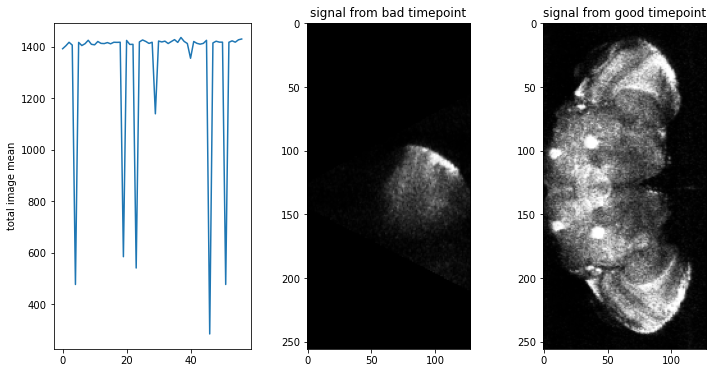

In [6]:
plot_image_means(mytx['motion_corrected'])

We can also compute the image similarity between each frame of the motion corrected image and the target (mean image), to see how well the image registration worked.

In [7]:
imgsim_rigid_moco = compute_similarity_to_mean(mytx['motion_corrected'], mean_ants)

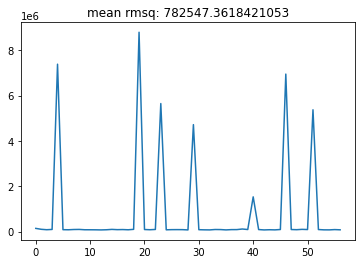

In [8]:
plt.plot(imgsim_rigid_moco)
plt.title(f'mean rmsq: {np.mean(imgsim_rigid_moco):.1f}')
mean_similarity['rigid_moco'] = np.mean(imgsim_rigid_moco)

### Rigid alignment using ants.registration

Our earlier experience had shown that motion correction using ants.registration worked well with this kind of data, so we test that here as well.

In [9]:
start = timer()
antsreg = ants.registration(fixed=mean_ants, moving=orig_ants,
                            type_of_transform='Rigid',
                            flow_sigma=flow_sigma,
                            total_sigma=total_sigma)
elapsed_time['rigid_antsreg'] = timer() - start
print(f'completed in {elapsed_time["rigid_antsreg"]:.2f} seconds')

completed in 1.01 seconds


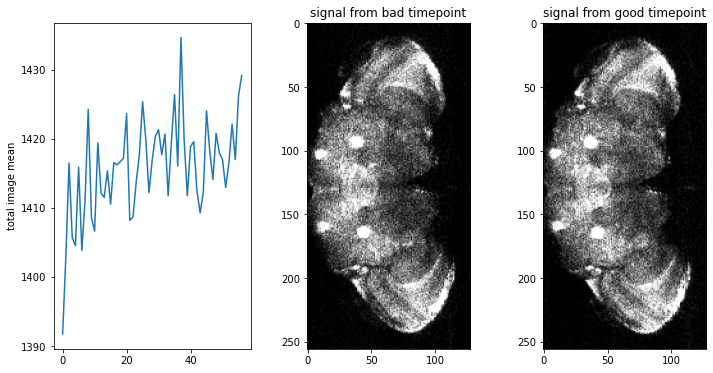

In [10]:
plot_image_means(antsreg['warpedfixout'])

In [11]:
imgsim_rigid_antsreg = compute_similarity_to_mean(antsreg['warpedfixout'], mean_ants)

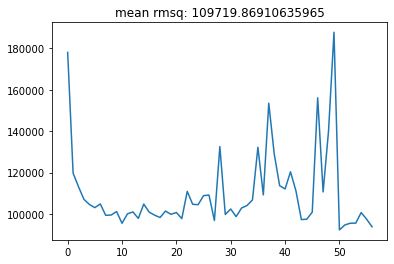

In [12]:
plt.plot(imgsim_rigid_antsreg)
plt.title(f'mean rmsq: {np.mean(imgsim_rigid_antsreg):.1f}')
mean_similarity['rigid_antsreg'] = np.mean(imgsim_rigid_antsreg)

### SyN correction using ants.motion_correction

In [13]:
start = timer()
mytx_syn = ants.motion_correction(image=orig_ants, fixed=mean_ants,
    verbose=True, type_of_transform='SyN',
    total_sigma=total_sigma, flow_sigma=flow_sigma)
elapsed_time['syn_moco'] = timer() - start
print(f'completed in {elapsed_time["syn_moco"]:.2f} seconds')

Progress:
0%.Done
completed in 418.34 seconds


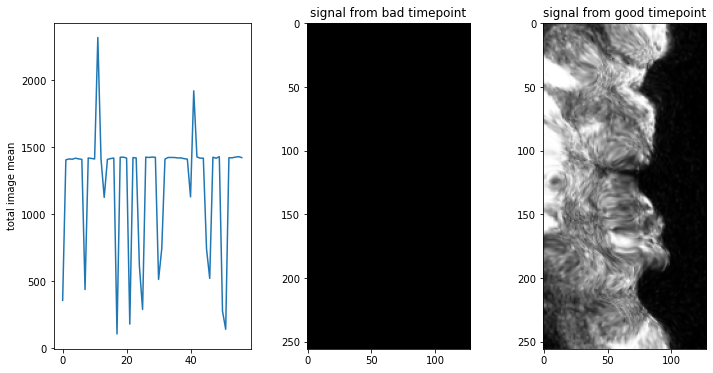

In [14]:
plot_image_means(mytx_syn['motion_corrected'])

In [15]:
imgsim_syn_moco = compute_similarity_to_mean(mytx_syn['motion_corrected'], mean_ants)

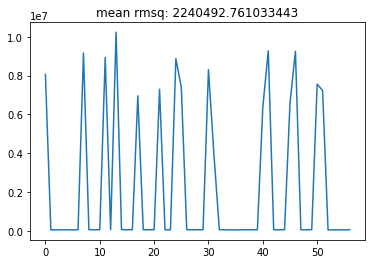

In [16]:
plt.plot(imgsim_syn_moco)
plt.title(f'mean rmsq: {np.mean(imgsim_syn_moco):.1f}')
mean_similarity['syn_moco'] = np.mean(imgsim_syn_moco)

### SyN registration using ants.registration

In [25]:
start = timer()
antsreg_syn = ants.registration(fixed=mean_ants, moving=orig_ants,
                            type_of_transform='SyN',
                            flow_sigma=flow_sigma,
                            total_sigma=total_sigma)
elapsed_time['syn_antsreg'] = timer() - start
print(f'completed in {elapsed_time["syn_antsreg"]:.2f} seconds')

completed in 1.02 seconds


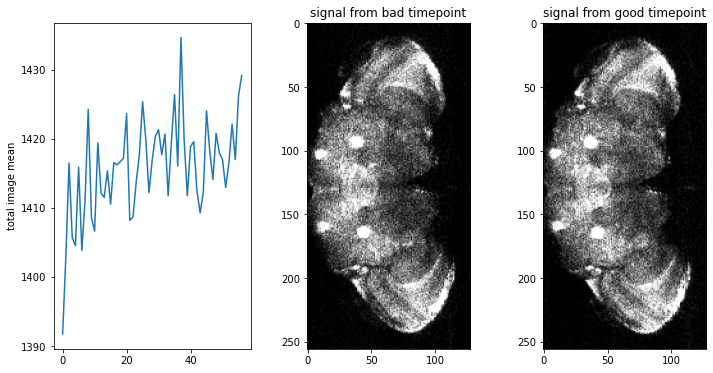

In [26]:
plot_image_means(antsreg_syn['warpedfixout'])

In [27]:
imgsim_syn_antsreg = compute_similarity_to_mean(antsreg_syn['warpedfixout'], mean_ants)

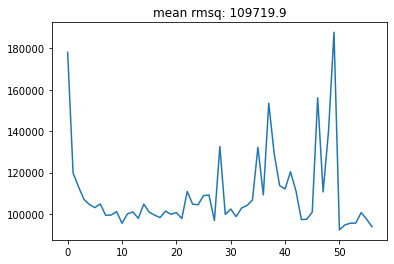

In [28]:
plt.plot(imgsim_syn_antsreg)
plt.title(f'mean rmsq: {np.mean(imgsim_syn_antsreg):.1f}')
mean_similarity['syn_antsreg'] = np.mean(imgsim_syn_antsreg)

In [29]:
mean_similarity

{'rigid_moco': 782547.3618421053,
 'rigid_antsreg': 109719.86910635965,
 'syn_moco': 2240492.761033443,
 'syn_antsreg': 109719.86910635965}

In [31]:
antsreg

{'warpedmovout': ANTsImage (LPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 128, 49)
 	 Spacing    : (0.0026, 0.0026, 0.005)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 128, 49, 57)
 	 Spacing    : (0.0026, 0.0026, 0.005, 0.532)
 	 Origin     : (0.0, 0.0, 0.0, 0.0)
 	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.],
 'fwdtransforms': [],
 'invtransforms': []}

In [33]:
idx=0
ants.image_similarity(
            ants.utils.slice_image(antsreg['warpedfixout'], axis=3, idx=idx),
            ants.utils.slice_image(orig_ants, axis=3, idx=idx))

0.0